In [1]:
import json
from dotenv import load_dotenv
import os
import time
from tqdm import tqdm
import random

import pymongo
from bson import ObjectId
import matplotlib.pyplot as plt

import consts
from schema import Character, Run, RunSummary

from rio_requests import character_run_summaries, get_run_from_id

In [2]:
database_runs = open('data/raideriknow.runs.json', 'r')
database_runs = json.load(database_runs)
database_runs = [Run.from_json(run) for run in database_runs]
database_run_ids = { run.keystone_run_id: run for run in database_runs }

database_characters = open('data/raideriknow.characters.json', 'r')
database_characters = json.load(database_characters)
database_characters = [Character.from_json(character) for character in database_characters]
database_characters = sorted(database_characters, key=lambda character: character.name)
database_character_ids = { character.id: character for character in database_characters }
database_character_oids = { character._id: character for character in database_characters }

In [3]:
print(len(database_characters))
print(len(database_runs))

77915
232433


In [4]:
def sample_runs(n) :
    return random.sample(database_runs, n)

def sample_characters(n) :
    return random.sample(database_characters, n)

def sample_database_runs_above_limit() :
    return [run for run in database_runs if run.mythic_level >= consts.MYTHIC_RUN_LEVEL_LIMIT]

def sample_database_characters_above_limit() :
    runs_above_limit = sample_database_runs_above_limit()
    character_oids = set()
    for run in runs_above_limit :
        roster = run.roster
        for char_oid in roster :
            character_oids.add(str(char_oid))
    
    return [database_character_oids[oid] for oid in character_oids]

database_runs_above_limit = sample_database_runs_above_limit()
database_characters_above_limit = sample_database_characters_above_limit()
print(len(database_characters_above_limit))
print(len(database_runs_above_limit))


55981
178274


In [5]:
"""
rough calculation
250,000 runs
each run has 5 characters
1,250,000 character-run operations
"""
def precompute_runs_per_character(d_runs) :
    runs_per_character = {}
    for run in tqdm(d_runs) :
        for character_oid in run.roster :
            character_id = str(character_oid)
            if character_id not in runs_per_character :
                runs_per_character[character_id] = []
            runs_per_character[character_id].append(run)

    return runs_per_character

runs_per_char = precompute_runs_per_character(database_runs)
runs_per_char_above_limit = precompute_runs_per_character(database_runs_above_limit)

100%|██████████| 178274/178274 [00:00<00:00, 1030276.25it/s]


In [6]:
def get_runs_with_character(character) :
    return runs_per_char[str(character._id)] if str(character._id) in runs_per_char else []

def get_runs_with_characters(characters) :
    runs = []
    for character in characters :
        runs += get_runs_with_character(character)
    return runs

In [7]:
example_character = database_characters[0]
example_runs = get_runs_with_character(example_character)
print(f'Example character: {example_character.name} ({example_character.id})')
print(f'Number of runs: {len(example_runs)}')
print(f'Example run: {example_runs[0].to_json()}')

Example character: Aackcamiwema (204603169)
Number of runs: 31
Example run: {'keystone_run_id': 22031134, 'completed_at': {'$date': '2024-01-25T02:00:34.000Z'}, 'dungeon': {'id': 9028, 'name': "Atal'Dazar"}, 'keystone_team_id': 266158471, 'mythic_level': 26, 'roster': [ObjectId('65e1303de63558d7ed4d0a3d'), ObjectId('65e13047e63558d7ed4d2c78'), ObjectId('65e1303de63558d7ed4d0aa0'), ObjectId('65e13047e63558d7ed4d2cf6'), ObjectId('65e1301de63558d7ed4ca7bf')], 'season': 'season-df-3', 'weekly_modifiers': ['Fortified', 'Incorporeal', 'Sanguine']}


In [8]:
def avg_runs_per_character(d_chars):
    avg_runs = 0
    no_run_characters = []
    for character in tqdm(d_chars):
        runs = get_runs_with_character(character)
        if len(runs) == 0:
            no_run_characters.append(character)
            continue

        avg_runs += len(runs)

    avg_runs /= (len(d_chars) - len(no_run_characters))
    # print(f'Number of characters with no runs: {len(no_run_characters)}')

    return avg_runs

avg_runs = avg_runs_per_character(database_characters)
print(f'Average number of runs per character: {avg_runs}')
avg_runs_above_limit = avg_runs_per_character(database_characters_above_limit)
print(f'Average number of runs per character above limit: {avg_runs_above_limit}')


100%|██████████| 77915/77915 [00:00<00:00, 1449066.16it/s]


Average number of runs per character: 14.989436210966218


100%|██████████| 55981/55981 [00:00<00:00, 1662934.28it/s]

Average number of runs per character above limit: 20.048230649684715


In [9]:
def avg_keystone_level(d_runs):
    avg_level = 0
    for run in tqdm(d_runs):
        avg_level += run.mythic_level

    avg_level /= len(d_runs)
    print(f'Average keystone level: {avg_level}')

avg_keystone_level(database_runs)
avg_keystone_level(database_runs_above_limit)

100%|██████████| 232433/232433 [00:00<00:00, 10977801.74it/s]


Average keystone level: 25.478318483175798


100%|██████████| 178274/178274 [00:00<00:00, 10757698.52it/s]

Average keystone level: 26.046961418939386


100%|██████████| 178274/178274 [00:00<00:00, 8209744.85it/s]


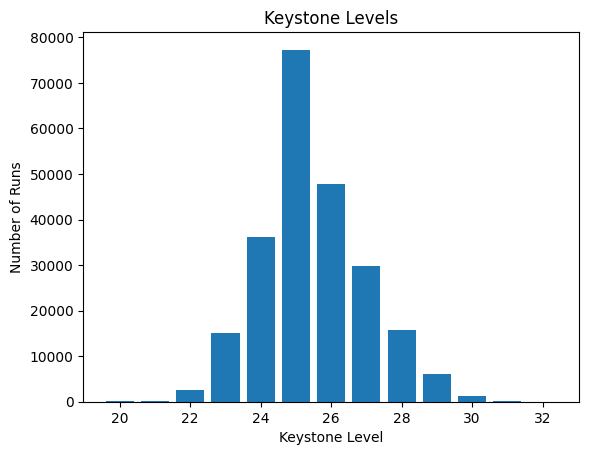

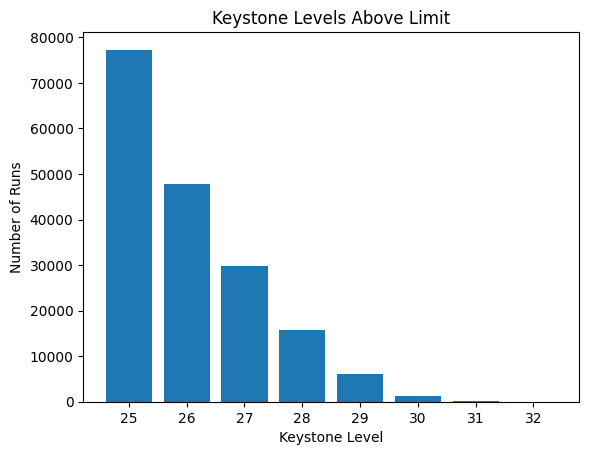

In [10]:
def runs_per_keystone_level(d_runs):
    levels = {}
    for run in tqdm(d_runs):
        level = run.mythic_level
        if level not in levels:
            levels[level] = 0
        levels[level] += 1

    return levels

levels = runs_per_keystone_level(database_runs)
levels_above_limit = runs_per_keystone_level(database_runs_above_limit)

def plot_levels(levels, title):
    plt.bar(levels.keys(), levels.values())
    plt.title(title)
    plt.xlabel('Keystone Level')
    plt.ylabel('Number of Runs')
    plt.show()

plot_levels(levels, 'Keystone Levels')
plot_levels(levels_above_limit, 'Keystone Levels Above Limit')